In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import trvae
from matplotlib import pyplot as plt
import os
import tensorflow as tf

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-package

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [6]:
SCRNA_DIR = '../data/scRNA/'

In [7]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna

CPU times: user 400 ms, sys: 3.62 s, total: 4.02 s
Wall time: 4.55 s


AnnData object with n_obs × n_vars = 53638 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

In [28]:
network = trvae.models.trVAE(scrna.shape[1],
                             z_dimension=20,
                             mmd_dimension=128,
                             n_conditions=2,
                             alpha=1e-6,
                             beta=500,
                             eta=100,
                             clip_value=1e6,
                             lambda_l1=0.0,
                             lambda_l2=0.0,
                             learning_rate=0.001,
                             dropout_rate=0.2,
                             model_path='./models/scrna/trvae/')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 3000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 3002)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 256)          768512      concatenate_15[0][0]       

In [29]:
history = network.train(scrna,
                        n_epochs=100,
                        batch_size=256,
                        verbose=2,
                        condition_key='condition')

Train on 42910 samples, validate on 10728 samples
Epoch 1/100
42910/42910 [==============================] - 8s 183us/step - loss: 24731.9592 - kl_mse_loss: 24684.3730 - mmd_loss: 39.1472 - kl_mse_kl_recon_loss: 24692.8262 - mmd_mmd_loss: 39.1472 - val_loss: 24581.2780 - val_kl_mse_loss: 24581.1602 - val_mmd_loss: 0.0000e+00 - val_kl_mse_kl_recon_loss: 24581.2793 - val_mmd_mmd_loss: 0.0000e+00
Epoch 2/100
42910/42910 [==============================] - 6s 141us/step - loss: 18665.2546 - kl_mse_loss: 18613.9473 - mmd_loss: 48.3027 - kl_mse_kl_recon_loss: 18616.9609 - mmd_mmd_loss: 48.3027 - val_loss: 20214.4031 - val_kl_mse_loss: 20213.9941 - val_mmd_loss: 0.0000e+00 - val_kl_mse_kl_recon_loss: 20214.4062 - val_mmd_mmd_loss: 0.0000e+00
Epoch 3/100
42910/42910 [==============================] - 5s 126us/step - loss: 16176.4850 - kl_mse_loss: 16132.4043 - mmd_loss: 43.0258 - kl_mse_kl_recon_loss: 16133.4590 - mmd_mmd_loss: 43.0258 - val_loss: 17681.8411 - val_kl_mse_loss: 17681.5391 - val_

TypeError: load_model() missing 1 required positional argument: 'filepath'

# Analysis

In [30]:
adata = scrna

### UMAP of the latent space

In [31]:
train_labels, _ = trvae.tl.label_encoder(adata, {'control': 0, 'stimulated': 1}, 'condition')

In [31]:
adata_latent = network.to_latent(adata, train_labels)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


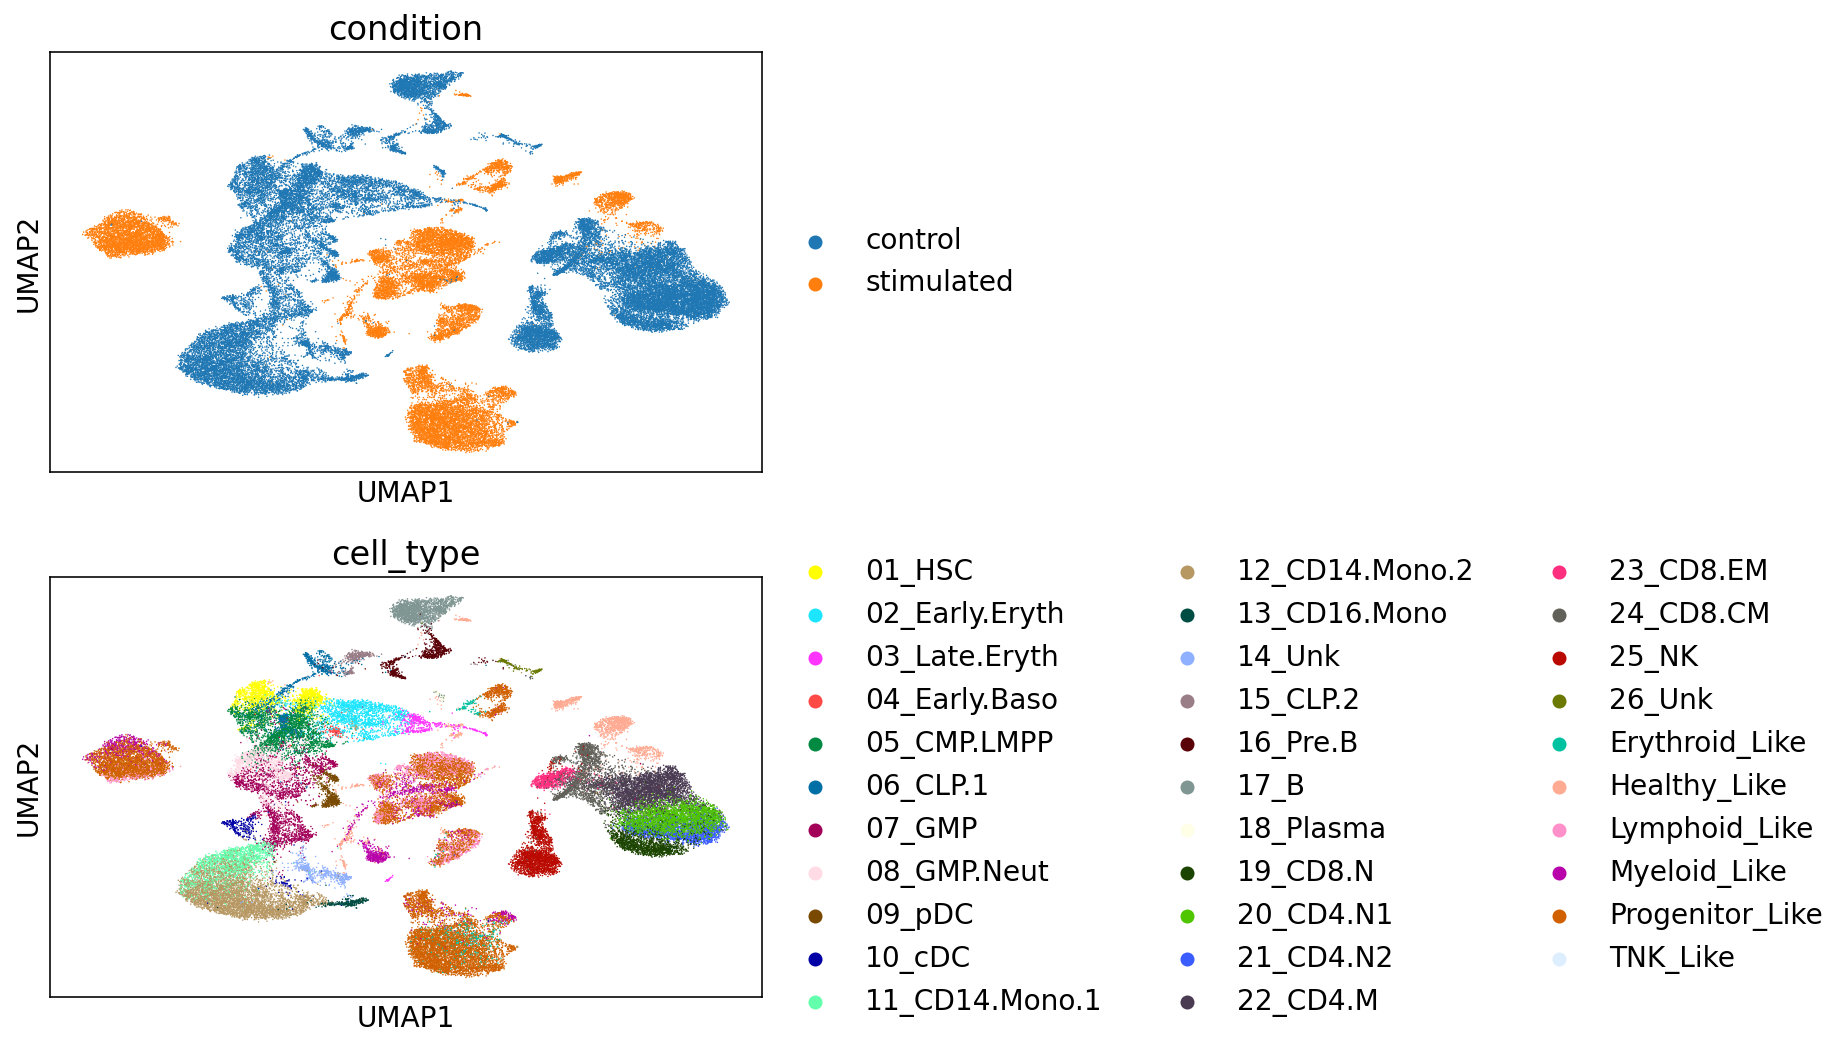

In [32]:
sc.pp.neighbors(adata_latent, random_state=42)
sc.tl.umap(adata_latent, random_state=42)
sc.pl.umap(adata_latent, color=['condition', 'cell_type'], ncols=1)

In [33]:
adata_mmd = network.to_mmd_layer(adata, train_labels, feed_fake=-1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


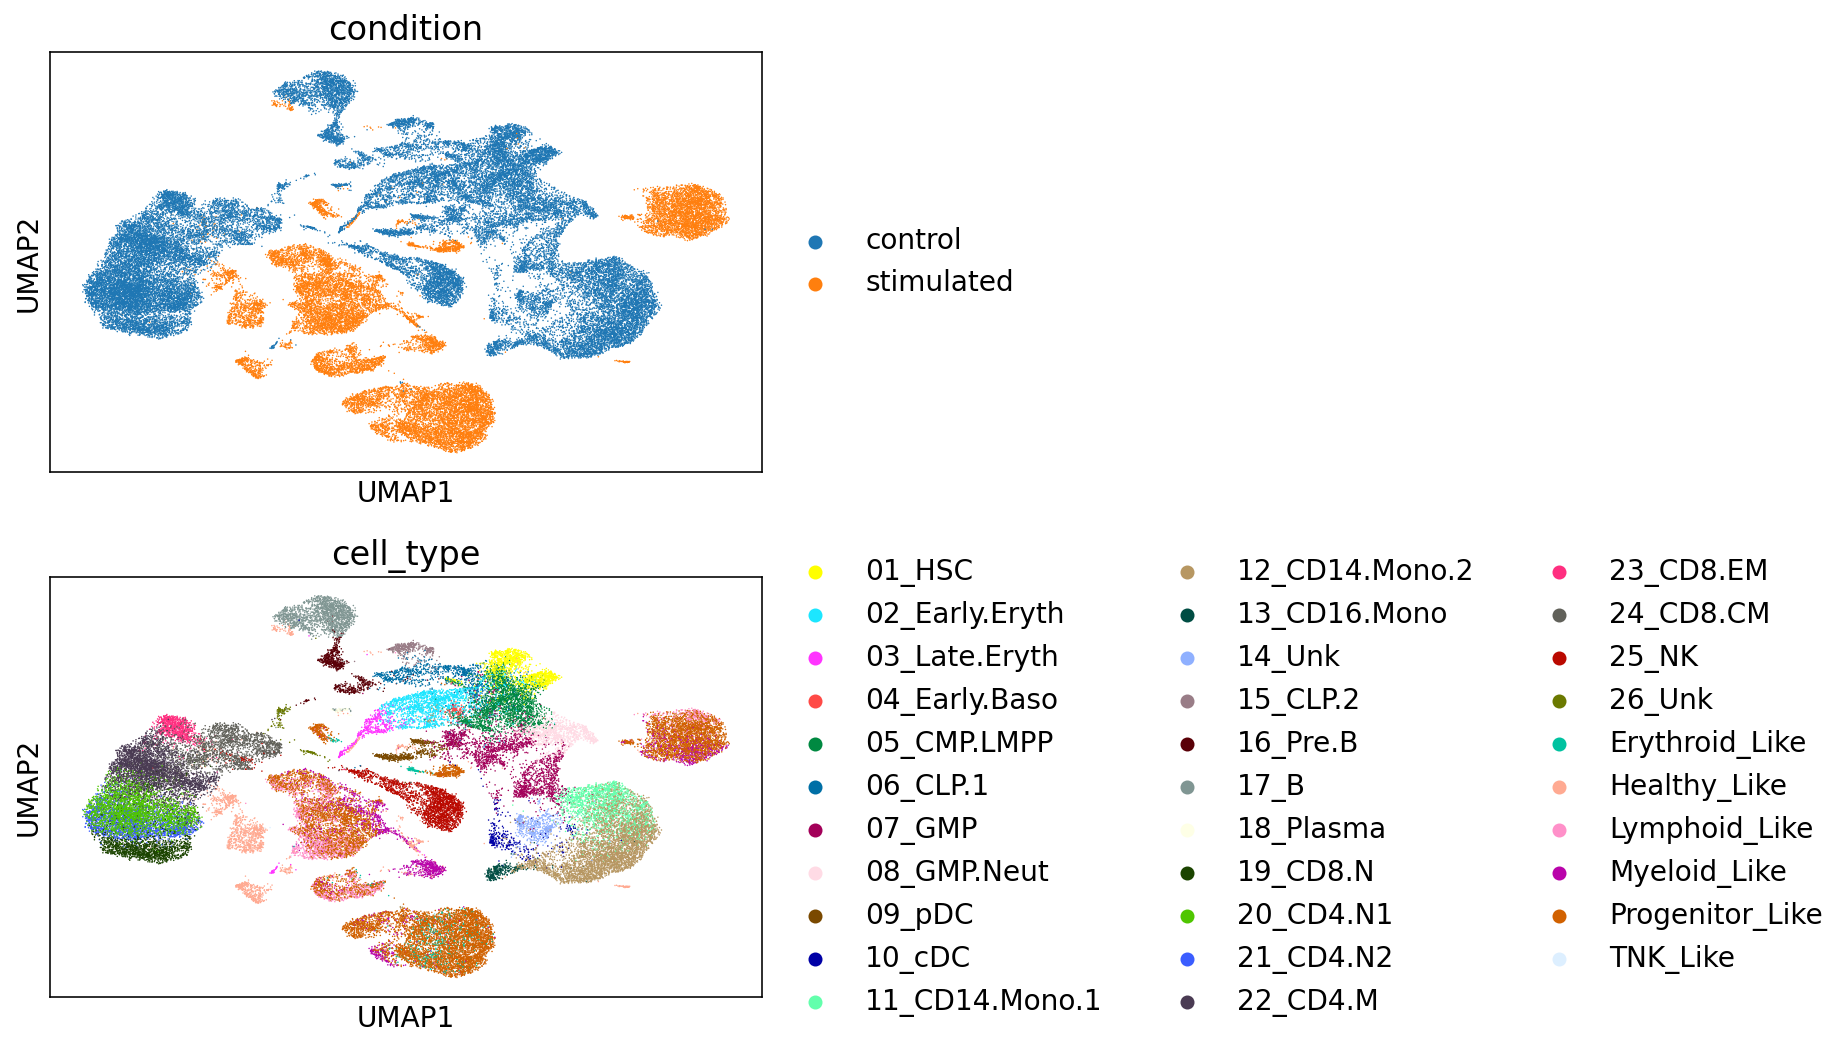

In [34]:
sc.pp.neighbors(adata_mmd, random_state=42)
sc.tl.umap(adata_mmd, random_state=42)
sc.pl.umap(adata_mmd, color=['condition', 'cell_type'], ncols=1)

### Predict control data

In [40]:
def predict_transition(adata, source_cond, target_cond):
    
    source_adata = adata[adata.obs['condition'] == source_cond]
    
    source_labels = np.zeros(source_adata.shape[0])
    target_labels = np.ones(source_adata.shape[0])

    pred_target = network.predict(source_adata,
                                  encoder_labels=source_labels,
                                  decoder_labels=target_labels)

    pred_adata = sc.AnnData(X=pred_target)
    pred_adata.obs['condition'] = 'predicted'
    pred_adata.var_names = source_adata.var_names

    adata = adata.concatenate(pred_adata)
    return adata

In [41]:
recon_adata = predict_transition(adata, "control", "stimulated")
recon_adata

AnnData object with n_obs × n_vars = 89220 × 3000 
    obs: 'Barcode', 'Group', 'batch', 'cell_type', 'condition', 'nGene', 'nUMI', 'nUMI_pre'
    var: 'gene_name-0', 'gene_id-0', 'exonLength-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0'

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

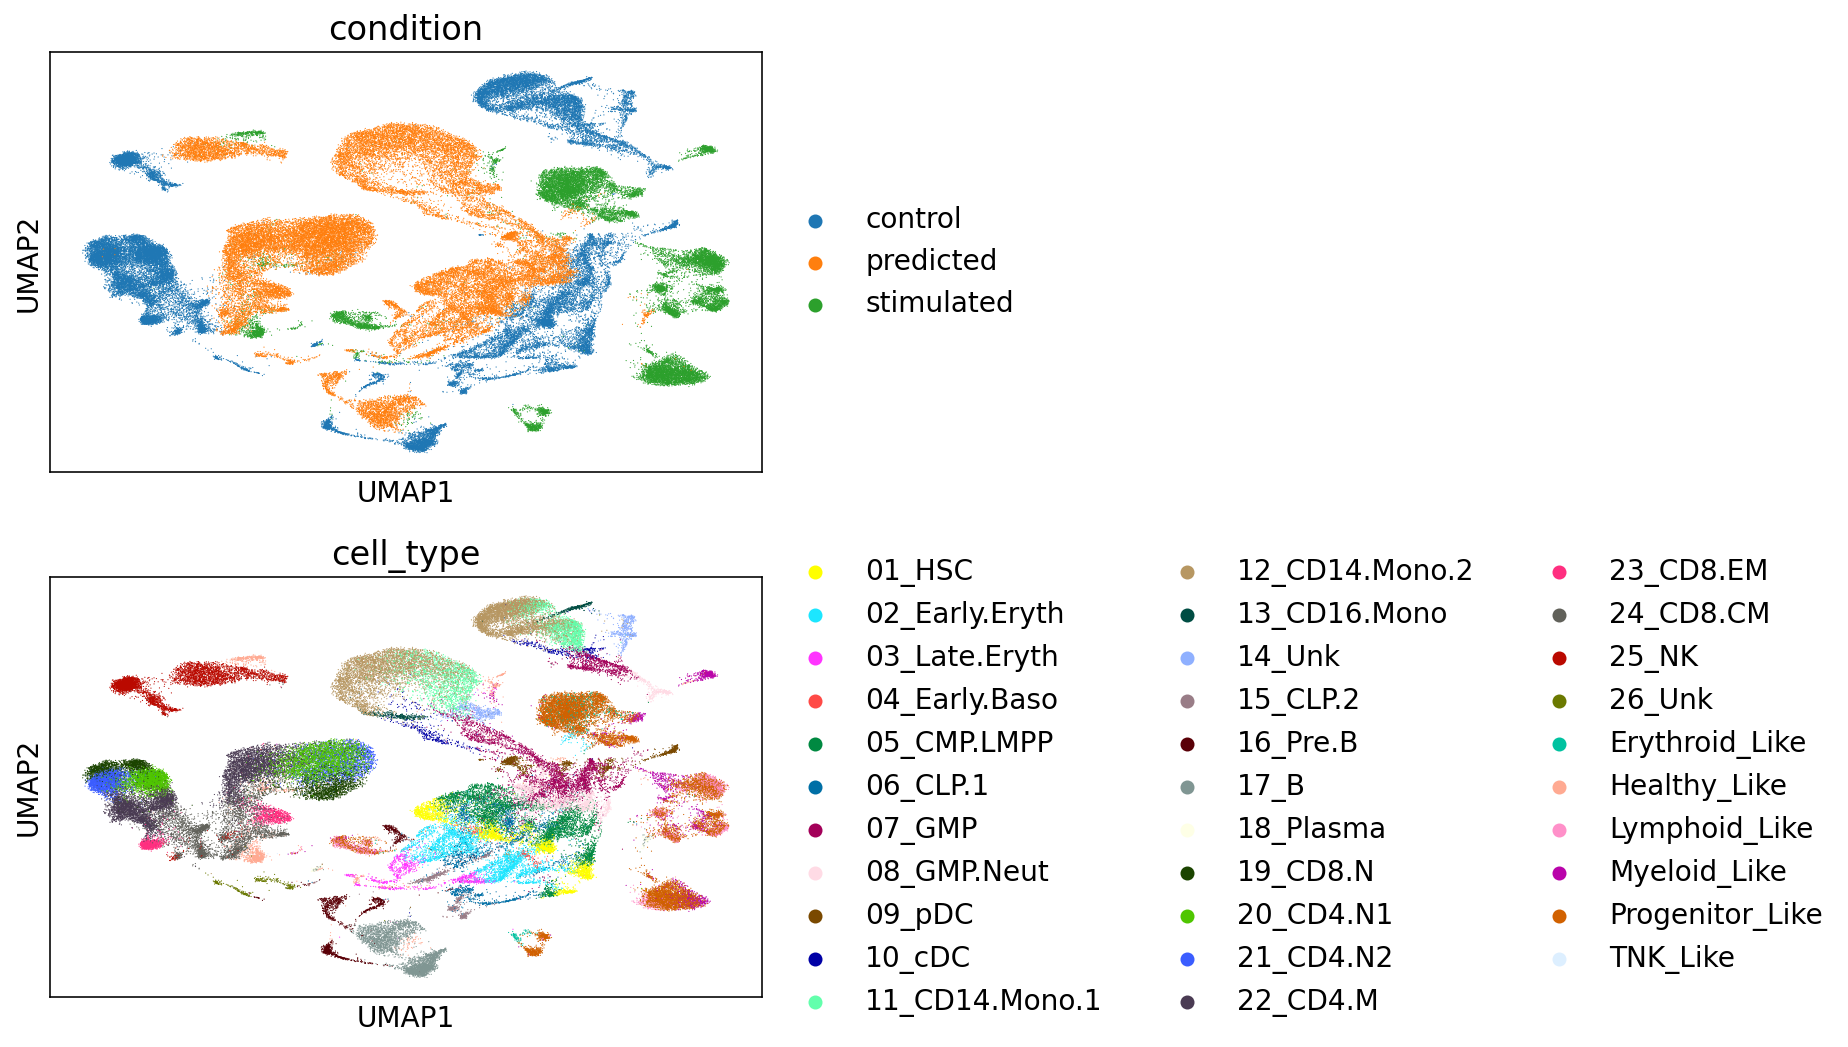

In [42]:
sc.pp.neighbors(recon_adata, random_state=42)
sc.tl.umap(recon_adata, random_state=42)
sc.pl.umap(recon_adata, color=['condition', 'cell_type'], ncols=1)

## Mean Correlation Plot

reg_mean_all: 0.9445742184747045


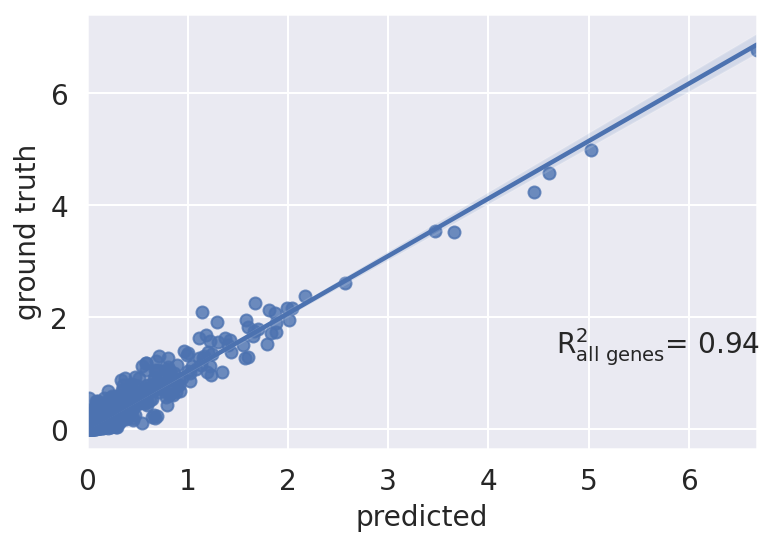

In [43]:
r2_value = trvae.plotting.reg_mean_plot(recon_adata, condition_key="condition",
                                        axis_keys={"x": "predicted", "y": "stimulated"},
                                        labels={"x": "predicted", "y": "ground truth"},
                                        show=True,
                                        legend=False)

reg_mean_all: 0.8930182515469444


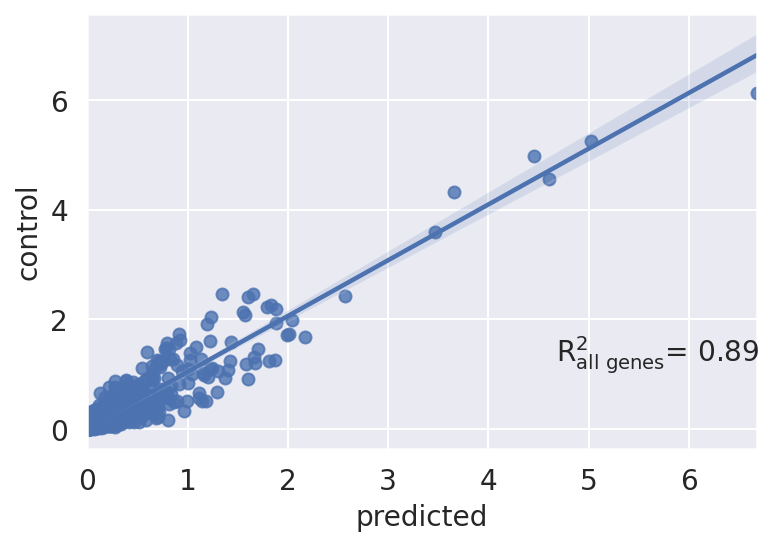

In [45]:
r2_value = trvae.plotting.reg_mean_plot(recon_adata, condition_key="condition",
                                        axis_keys={"x": "predicted", "y": "control"},
                                        labels={"x": "predicted", "y": "control"},
                                        show=True,
                                        legend=False)

reg_mean_all: 0.7482523588414879


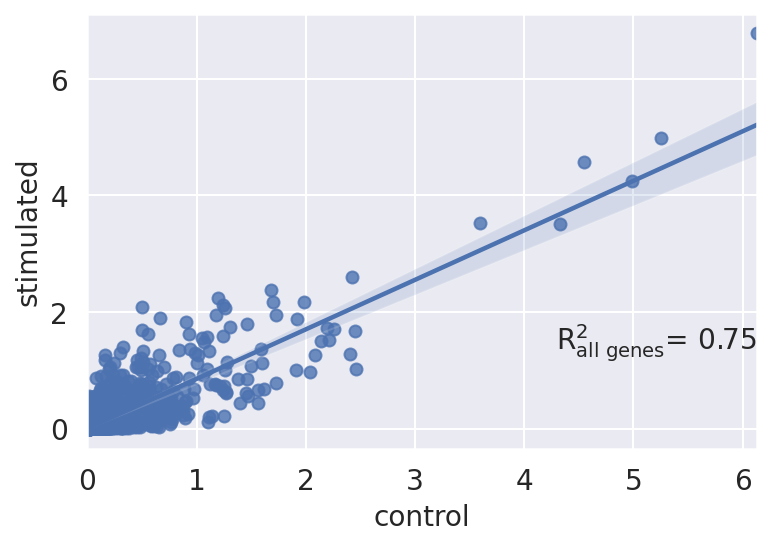

In [46]:
r2_value = trvae.plotting.reg_mean_plot(recon_adata, condition_key="condition",
                                        axis_keys={"x": "control", "y": "stimulated"},
                                        labels={"x": "control", "y": "stimulated"},
                                        show=True,
                                        legend=False)